#  Проект "Прогнозирование заказов такси"

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

### Импорт библиотек и загрузка данных

Импортируем необходимые библиотеки и модули:

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, make_scorer
from lightgbm import LGBMRegressor

Получаем данные из исходной таблицы:

In [3]:
taxi = pd.read_csv('/datasets/taxi.csv', parse_dates=['datetime'], index_col='datetime')

Посмотрим примеры нескольких строк:

In [4]:
taxi.head(7)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7


Посмотрим общую информацию по исходной таблице:

In [5]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


Периодичность сбора данных - 1 раз в 10 минут (необходимо провести ресемплирование до 1 часа).

Пропущенных значений нет.

### Ресемплирование

Проводим ресемлирование временных данных по одному часу (с сортировкой временных индексов, если это необходимо):

In [6]:
if taxi.index.is_monotonic:
    taxi = taxi.resample('1H').sum()
else:
    taxi = taxi.sort_index()    
    taxi = taxi.resample('1H').sum()

Посмотрим на изменения:

In [7]:
taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Убедимся, что количество строк сократилось

In [8]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
num_orders    4416 non-null int64
dtypes: int64(1)
memory usage: 69.0 KB


## Анализ

### Скользящее среднее

Посмотрим на скользящее среднее и скользящее стандартное отклонение по 2 неделям:

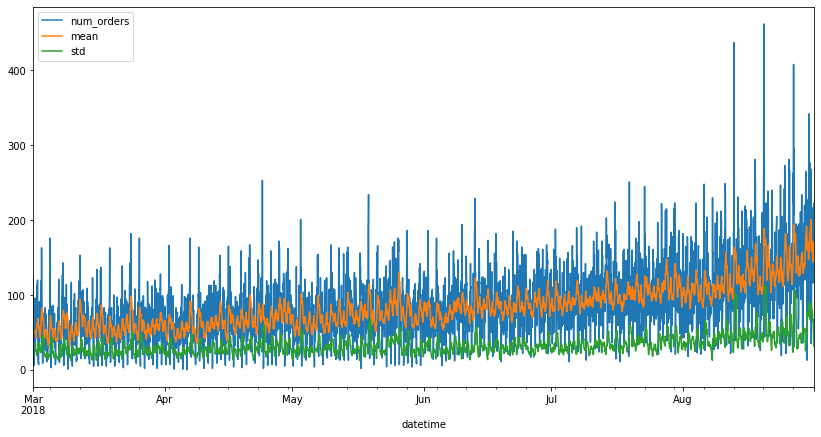

In [9]:
roll_taxi = taxi.copy()
roll_taxi['mean'] = roll_taxi['num_orders'].rolling(14).mean()
roll_taxi['std'] = roll_taxi['num_orders'].rolling(14).std()
roll_taxi.plot(figsize=(14,7))

### Тренд и сезонность

Оценим тренд и сезонностей в рамках недели и в рамках суток:

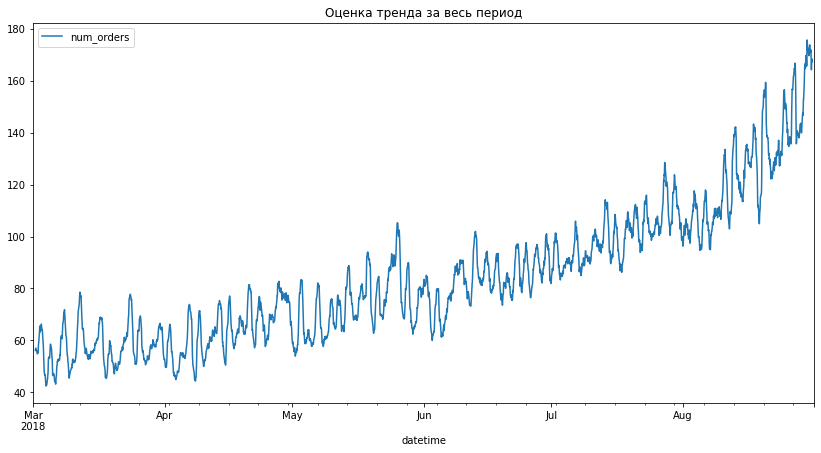

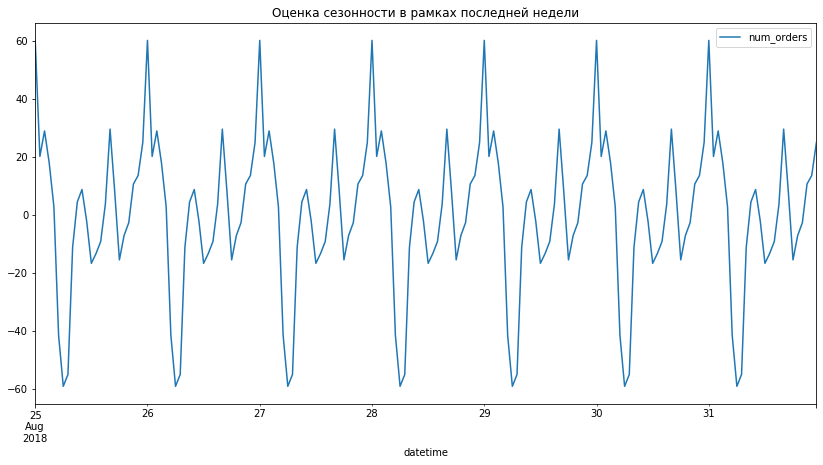

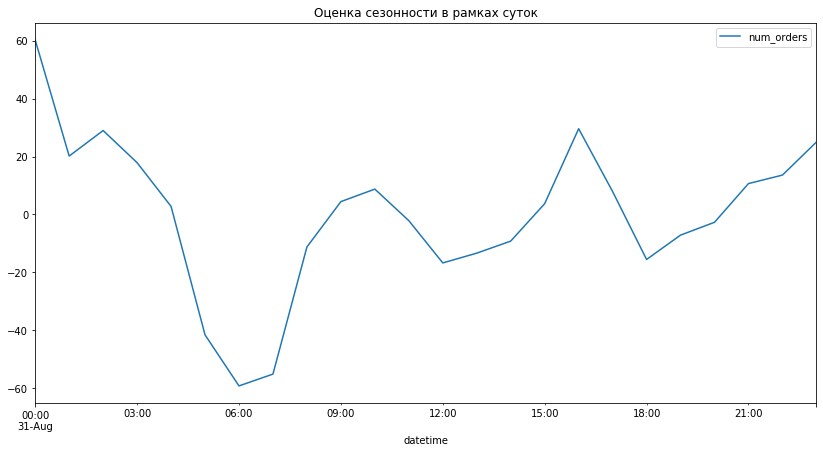

In [10]:
decomposed_data = seasonal_decompose(taxi.dropna())

decomposed_data.trend.plot(figsize=(14,7), 
                           title='Оценка тренда за весь период')

decomposed_data.seasonal.tail(24*7).plot(figsize=(14,7), 
                                         title='Оценка сезонности в рамках последней недели')

decomposed_data.seasonal.tail(24).plot(figsize=(14,7), 
                                         title='Оценка сезонности в рамках суток')

#decomposed_data.resid.plot(figsize=(14,7), title='Остатки (Resid)')

**Результаты анализа:**

* Количество заказов такси стабильно растёт в течение всего периода наблюдений.
* Нет возможности оценить сезонность в течение года из-за отсутствия необходимых данных.
* Отсутствует сезонность в рамках дней недели
* Присутствует сезонность в течение дня: минимальное количество заказов - с 5 до 7 утра, максимальное - в районе полуночи

## Обучение

### Создание признаков

Создадим признаки, на которых будут обучаться модели:
* Час вызова такси (анализ выше показал наличие сезонности в течение суток) - в виде категориальной переменной с преобразованием признаков техникой OHE.
* Значения за соответствующий час со сдвижкой за последние 2 недели (предполагаем, что это учтёт влияние тренда)
* Скользящее среднее за последние 2 недели.

Первые 2 недели при этом, в связи с отсутствием предыдущих значений, удалим.

In [11]:
for lag in range(1, 15):
        taxi['lag_{}'.format(lag)] = taxi['num_orders'].shift(lag*24)

taxi['hour'] = taxi.index.hour.astype("category")
        
taxi['rolling_mean'] = taxi['num_orders'].shift().rolling(14).mean()

taxi = pd.get_dummies(taxi, drop_first=True)

taxi = taxi.dropna()

Убеждаемся, что получили то, что было задумано.

In [12]:
pd.options.display.max_columns = None
display(taxi.head(50))

,num_orders,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,rolling_mean,hour_1,hour_2,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-03-15 00:00:00,123,84.0,91.0,102.0,81.0,117.0,84.0,143.0,100.0,42.0,86.0,75.0,163.0,90.0,124.0,62.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2018-03-15 01:00:00,85,72.0,88.0,153.0,83.0,78.0,66.0,78.0,121.0,75.0,176.0,60.0,108.0,120.0,85.0,67.500000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2018-03-15 02:00:00,55,39.0,58.0,57.0,36.0,24.0,29.0,65.0,24.0,36.0,32.0,26.0,25.0,75.0,71.0,69.428571,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2018-03-15 03:00:00,42,57.0,63.0,51.0,49.0,44.0,31.0,68.0,66.0,49.0,51.0,42.0,64.0,64.0,66.0,70.428571,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2018-03-15 04:00:00,15,21.0,42.0,49.0,30.0,46.0,30.0,60.0,73.0,30.0,34.0,27.0,44.0,20.0,43.0,68.642857,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2018-03-15 05:00:00,20,15.0,17.0,31.0,11.0,12.0,1.0,6.0,10.0,36.0,16.0,22.0,15.0,11.0,6.0,64.571429,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2018-03-15 06:00:00,5,19.0,15.0,15.0,16.0,5.0,4.0,6.0,19.0,7.0,3.0,11.0,9.0,11.0,12.0,62.357143,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2018-03-15 07:00:00,17,8.0,20.0,19.0,14.0,18.0,16.0,19.0,17.0,10.0,14.0,12.0,17.0,7.0,15.0,58.500000,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2018-03-15 08:00:00,33,35.0,57.0,75.0,43.0,46.0,36.0,77.0,38.0,25.0,31.0,39.0,56.0,46.0,34.0,55.642857,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Разделение на выборки

Разделяем выборки с обязательным указанием shuffle=False для того, чтобы не нарушать порядок временных рядов.

In [13]:
train, test = train_test_split(taxi, shuffle=False, test_size=0.1)

Определяем целевой признак и прочие признаки.

In [14]:
X = train.drop(['num_orders'], axis=1)
y = train['num_orders']
X_test = test.drop(['num_orders'],axis=1)
y_test = test['num_orders']

print('Размер обучающей выборки:', X.shape)
print('Размер тестовой выборки:', X_test.shape)

Размер обучающей выборки: (3672, 38)
Размер тестовой выборки: (408, 38)


### Модели

#### Предсказания по вчерашнему дню (базовая модель)

В качестве базовой модели, в том числе для проверки на адекватность последующих моделей, попробуем просто предсказывать новые значения значениями за тот же час предыдущего дня.

In [15]:
df_yesterday = test.copy()
df_yesterday['yesterday'] = df_yesterday['num_orders'].shift(24)
df_yesterday = df_yesterday.dropna()

rmse_yesterday = mean_squared_error(df_yesterday['num_orders'], df_yesterday['yesterday']) ** 0.5
print("RMSE предсказаний по вчерашнему дню:", round(rmse_yesterday, 3))

RMSE предсказаний по вчерашнему дню: 56.755


#### Линейная регрессия

Обучение линейной регрессии проводим на обучающей выборке, проверку - на тестовой.

In [16]:
%%time
lr = LinearRegression()
lr.fit(X,y)
lr_predictions = lr.predict(X_test)
print('RMSE линейной регрессии:', mean_squared_error(y_test, lr_predictions) ** 0.5)

RMSE линейной регрессии: 34.261044993299
CPU times: user 21.4 ms, sys: 26 ms, total: 47.4 ms
Wall time: 9.78 ms


#### Градиентный бустинг LightGBM

In [18]:
%%time

gb_rmse = []

for est in range(100, 301, 100):
    for depth in range (3, 5, 1):
        for lr in [0.1, 0.25, 0.5]:
            gb_model = LGBMRegressor(n_estimators=est, learning_rate=lr, max_depth=depth, random_state=12345)
            gb_model.fit(X,y)
            mse = cross_val_score(gb_model, X, y, cv=TimeSeriesSplit(n_splits=3).split(X), 
                                  scoring = make_scorer(mean_squared_error))
            rmse = np.sqrt(mse).mean()
            gb_rmse.append({'n_estimators': est,
                            'max_depth': depth,
                            'learning_rate': lr,
                            'RMSE': rmse})

gb_rmse = pd.DataFrame(gb_rmse)

gb_rmse

CPU times: user 1min 2s, sys: 560 ms, total: 1min 3s
Wall time: 1min 3s


,n_estimators,max_depth,learning_rate,RMSE
0,100,3,0.10,23.822824
1,100,3,0.25,24.740515
2,100,3,0.50,26.563418
3,100,4,0.10,23.941966
4,100,4,0.25,24.608381
5,100,4,0.50,26.226497
6,200,3,0.10,24.134115
7,200,3,0.25,25.287392
8,200,3,0.50,27.107019
9,200,4,0.10,24.281719


## Тестирование

Наилучшие результаты при подготовке моделей показал алгоритм градиентного бустинга.

Проверим его результаты на тестовой выборке.

In [19]:
gb_model = LGBMRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=12345)
gb_model.fit(X,y)
gb_predictions = gb_model.predict(X_test)
print('RMSE градиентного бустинга на тестовой выборке:', mean_squared_error(y_test, gb_predictions) ** 0.5)

RMSE градиентного бустинга на тестовой выборке: 36.726457102029215


**Результаты проекта:**
* Исходные данные по количеству заказов такси были импортированы, было проведено их ресемплирование.
* В ходе анализа были определены:
    * Общий тренд на рост количества заказов в течение оцениваемого периода;
    * Сезонность в рамках суток и отсутствие сезонности в рамках дней недели.
* На базе проведённого анализа были сформированы признаки для обучения различных моделей.
* При обучении моделей наилучшие результаты по метрике RMSE показала модель по алгоритму градиентного бустинга LightGBM.
* Её проверка на тестовой выборке подтвердила успешность модели. RMSE ~36,73 значительно ниже (лучше), чем требуемые 48.